In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
sns.set_theme()
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
names = [f"feature {i}" for i in range(28)]
names.insert(0, "Label")

In [4]:
df = pd.read_csv('/content/drive/MyDrive/HIGGS_6M.csv.gz', header=None, names=names, compression = 'gzip')

In [5]:
df.head()

,Label,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11,feature 12,feature 13,feature 14,feature 15,feature 16,feature 17,feature 18,feature 19,feature 20,feature 21,feature 22,feature 23,feature 24,feature 25,feature 26,feature 27
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


# Data distribution

The dataset is balanced. Around 54% of samples belong to class 1 and, 46% belongs to class 0.
This implies that no under-sampling or over-sampling techniques are required.

In [6]:
class_len = df.Label.value_counts().to_dict()

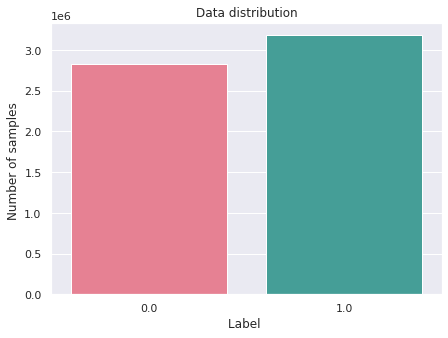

In [7]:
plt.figure(figsize=(7,5))
sns.barplot(x=np.array(list(class_len.keys())), y=np.array(list(class_len.values())), palette = "husl")
plt.title("Data distribution")
plt.xlabel('Label ')
plt.ylabel('Number of samples ')
plt.xticks([0,1])
plt.show()

# Correlation

Another important aspect to consider is the correlation between features. A too close correlation between two or more features can adversely affect classifier performance. The correlation matrix, which is made up of correlation coefficients, helps us identify those relationships. Correlation is a function of covariance, as we can see from the Pearson index:
<img src=https://raw.githubusercontent.com/MarcoChain/Matematichs-in-machine-learning-tesina/master/image13.JPG>

As we can see from the below graph, we have some highly correlated features. We expected this result since the last seven features are obtained from the other twenty-one. In general, high correlated predictors are removed because they could adversely affect the performance of the classifier. In this situation, these features were  computed by a domain expert so, they might be particularly useful. For this reason, I prefer to keep all the twenty-eight features in the dataset. Another aspect to note is that all the features are very poorly correlated with the label. This means this stack could be really hard to solve. I prefer to not add any other features as it is at odds with the title and idea of the exercise.

In [8]:
corr = df.corr()

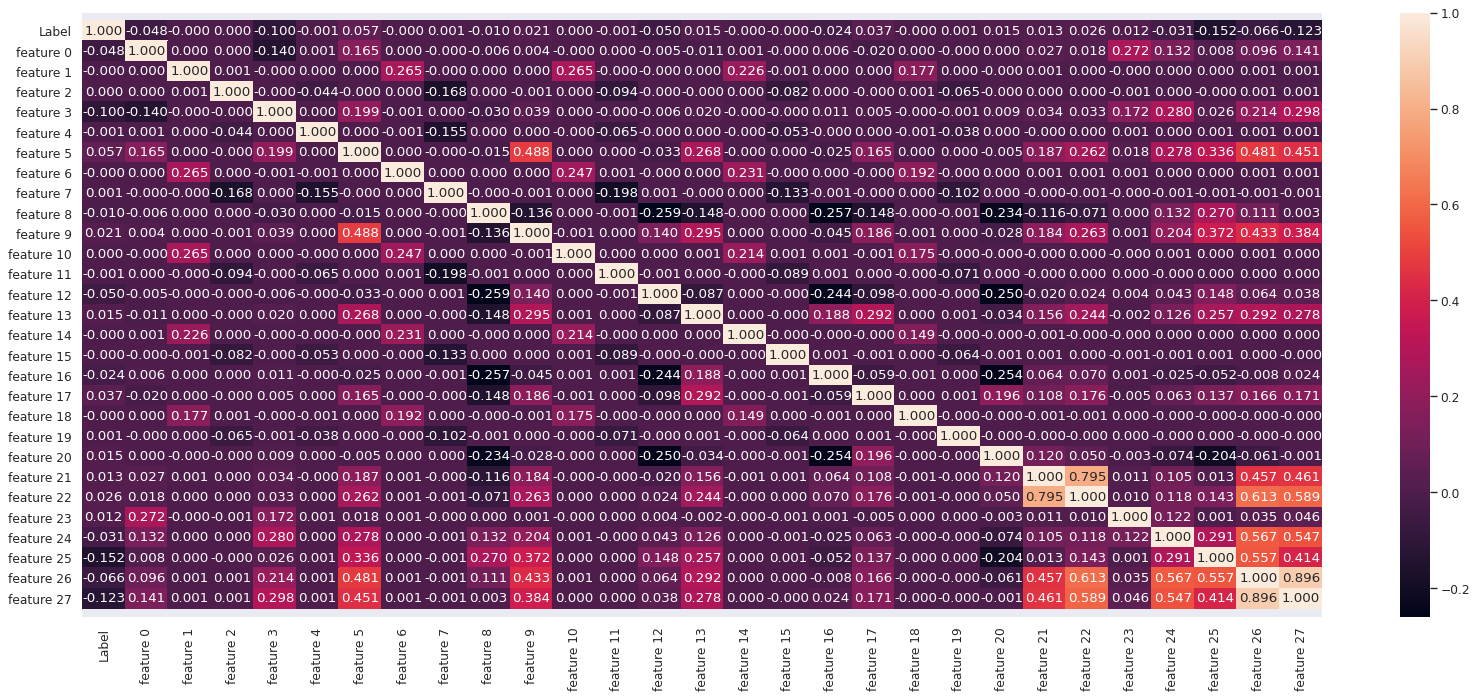

In [9]:
plt.figure(figsize=(25,10), dpi=80)
ax = sns.heatmap(corr, annot=True, fmt = ".3f")
bottom, top = ax.get_ylim()
ris = ax.set_ylim(bottom + 0.4, top - 0.4)

# Methods

In [10]:
#method to plot the accuracy and loss of training and validation set
def plot_acc_loss(history, n_epochs):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (25,7))
  axs[0].plot(np.arange(1,n_epochs+1), history.history['sparse_categorical_accuracy'], '-o')
  axs[0].plot(np.arange(1,n_epochs+1), history.history['val_sparse_categorical_accuracy'], '-o')
  axs[0].set_title('model accuracy')
  axs[0].set_ylabel('accuracy')
  axs[0].set_xlabel('epoch')
  axs[0].legend(['train', 'val'], loc='upper left')
  #plt.gca().set_ylim(0,1)
  axs[1].plot(np.arange(1,n_epochs+1), history.history['loss'], '-o')
  axs[1].plot(np.arange(1,n_epochs+1), history.history['val_loss'], '-o')
  axs[1].set_title('model loss')
  axs[1].set_ylabel('loss')
  axs[1].set_xlabel('epoch')
  axs[1].legend(['train', 'val'], loc='upper left')

In [11]:
def create_datasets(pca = False):
  ds = df.to_numpy()
  X = ds[:,1:]
  y = ds[:, 0]
  d = X.shape[1]

  scaler = StandardScaler()
  X_s = scaler.fit_transform(X)
  # Applying PCA
  if pca is True:
    pca = PCA()
    pca.fit(X_s)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= 0.85)
    plt.figure(figsize = (15,7))
    plt.title("Explained variance as a function of the number of dimensions")
    plt.plot(cumsum, label = "Explained variance")
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Prop. Variance Explained")
    plt.plot(np.ones(28) * 0.85, color = "red", ls = "--", label = "85% Threshold")
    plt.axvline(x=d, color = "red", ls = "--",)
    plt.legend()
    
    pca = PCA(n_components=d)
    X_s = pca.fit_transform(X_s)
  
  # split the dataset randomly
  X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.33, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

  BATCH_SIZE = 1024
  SHUFFLE_BUFFER_SIZE = 100

  # create the tensorflow datasets
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

  train_dataset = train_dataset.cache()
  val_dataset = val_dataset.cache()

  train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
  test_dataset = test_dataset.batch(BATCH_SIZE)
  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
  val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  return train_dataset, val_dataset, test_dataset, y_test, d

## Deep Models

In [12]:
# Deep models using convolutional layers
def create_conv_model(input_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Reshape((4,7), input_shape=(input_size,)),
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 1, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Conv1D(filters = 128, kernel_size = 2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Conv1D(filters = 256, kernel_size = 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])
  return model

In [13]:
# Deep models using Dense layers
def create_dense_model(input_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_size,)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2)
])
  model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])
  return model

# Point A

Your first task is to build one or more machine learning classifiers to separate the two
classes of events. Please provide the ROC curve that shows the classifier performance.
We suggest that you evaluate the final performance of your classifier on the last 500k
samples. Be careful to not overfit the test dataset, as we will evaluate your model
on another holdout dataset.

In [14]:
train_dataset, val_dataset, test_dataset, y_test, _ = create_datasets()

In [15]:
model_c = create_conv_model(input_size = 28)
model_c.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 32)             256       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 32)             128       
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64)             256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 64)             0

You can test this exercise with both the multilayer perceptron or the convolutional neural network but, the result obtained by the second model are slightly better than the first one. 
Either way, the two models are quite similar and share most of the layers. 
To reduce overfitting, I used both dropout and batch normalization layers. Deeper models can be used to boost the performances but, I think that it is out of scope. Moreover, having smaller models results in fewer networks parameters and this can help to reduce the overfitting problem.
Since we are dealing with a large dataset, we set the batch size to 1024. This solution implies increasing the value of the learning rate of our optimizer (Adam) from 1e-3 to 5e-3. 

In [16]:
history = model_c.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
3534/3534 [==============================] - 62s 12ms/step - loss: 0.5407 - sparse_categorical_accuracy: 0.7191 - val_loss: 0.5015 - val_sparse_categorical_accuracy: 0.7478
Epoch 2/10
3534/3534 [==============================] - 43s 12ms/step - loss: 0.4987 - sparse_categorical_accuracy: 0.7510 - val_loss: 0.4902 - val_sparse_categorical_accuracy: 0.7564
Epoch 3/10
3534/3534 [==============================] - 43s 12ms/step - loss: 0.4881 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.4811 - val_sparse_categorical_accuracy: 0.7620
Epoch 4/10
3534/3534 [==============================] - 43s 12ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.4783 - val_sparse_categorical_accuracy: 0.7644
Epoch 5/10
3534/3534 [==============================] - 44s 13ms/step - loss: 0.4763 - sparse_categorical_accuracy: 0.7660 - val_loss: 0.4762 - val_sparse_categorical_accuracy: 0.7655
Epoch 6/10
3534/3534 [==============================] - 44s 12ms/step - loss: 0.

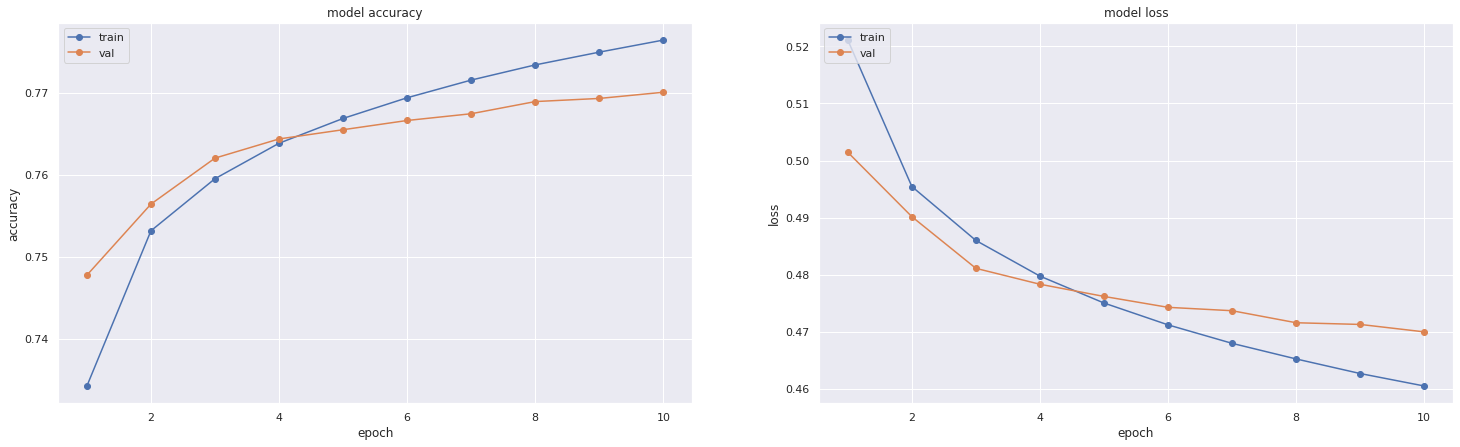

In [17]:
plot_acc_loss(history, 10)

A ROC curve is used to measures the performance of a binary classification task. The plot shows the true-positive rate (TPR) against the false-negative rate (FNR) at various threshold settings. They are defined as follows:

\begin{align}
TPR= \frac{TP}{TP + FN}
\end{align}

\begin{align}
FPR= \frac{FP}{FP + TN}
\end{align}

This plot is used to determine if the model achieves a good separability between the two classes. Looking at the curve, the area beneath it is called AUC. The higher the AUC, the better the model is at predicting the labels. The best-case scenario is AUC equal to 1. When AUC is close to 0, it means it has the worst measure of separability since it is predicting the wrong class label every time. Instead, when AUC is 0.5, it means the model has no class separation capacity and acts like random guess.

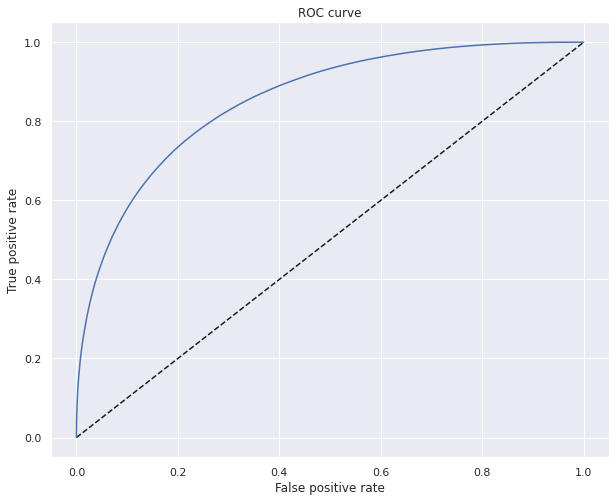

In [18]:
y_pred = model_c.predict(test_dataset)
fpr_rf, tpr_rf, _ = roc_curve(y_test, tf.nn.softmax(y_pred)[:, 1])
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [19]:
model_c.evaluate(test_dataset)

1934/1934 [==============================] - 9s 4ms/step - loss: 0.4705 - sparse_categorical_accuracy: 0.7691


[0.47053152322769165, 0.7690898776054382]

The final performance on the test underlines what already seen in the validation set. This result, joined to the ROC curve, underlines that the model is performing well and is not overfitting the training set. The main objective now is to develop a feature extractor that will maintain this level of performance obtained.

# Point B

Your next task is to apply one (or several) machine learning dimensionality reduction
techniques of your choice to reduce the dimensionality of the problem as much as
possible, without losing significant classification performance of your classifier. Please
provide the ROC curve showing the performance of the reduced model and a set of
features used by the model. Be careful to not overfit the test dataset, as we will
again evaluate your model on another holdout dataset.

## CNN as feature extractor

The main idea to reduce the dimensionality of the problem is to use the CNN that we have already trained and use it as a features extractor. This technique is widely used in the image classification task as shown by Jogin et al. (https://ieeexplore.ieee.org/document/9012507) or Liu et al. (https://arxiv.org/pdf/1904.04447.pdf). So, what we can try is to remove the last fully connected layer and maintain all the other others layers. In this way, the new network ends up with ten neurons that we can use as new features. So, after that, we can train any other classifier based on this new features space. What is remarkable is that we can even shrink the number of neurons of the last layer practically as much as we want. For simplicity in this example, we will try only with the 10-feature space. 
By applying a shallow algorithm like Random Forest, without any type of hyperparameter tuning, we practically obtain the same result as before. This highlight that this solution can be very powerful and theoretically can be applied to any problem.

In [20]:
model_half = tf.keras.Sequential() # create the feature extractor model
for layer in model_c.layers[:-1]: # go through until last layer
    model_half.add(layer)

In [21]:
model_half.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 4, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4, 32)             256       
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 32)             128       
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64)             256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 4, 64)            

In [22]:
ds = df.to_numpy()
X = ds[:,1:]
y = ds[:, 0]
d = X.shape[1]

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_s, y, test_size=0.33, random_state=42)

X_new_train = model_half.predict(X_new_train) #converting the new features in the new ones
X_new_test = model_half.predict(X_new_test)

In [23]:
clf = RandomForestClassifier(random_state = 43, max_depth = 3) #train the Linear SVM
clf.fit(X_new_train, y_new_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)

In [24]:
y_pred = clf.predict(X_new_test)
accuracy_score(y_new_test, y_pred) # The accuracy is practically the same of before

0.7685272727272727

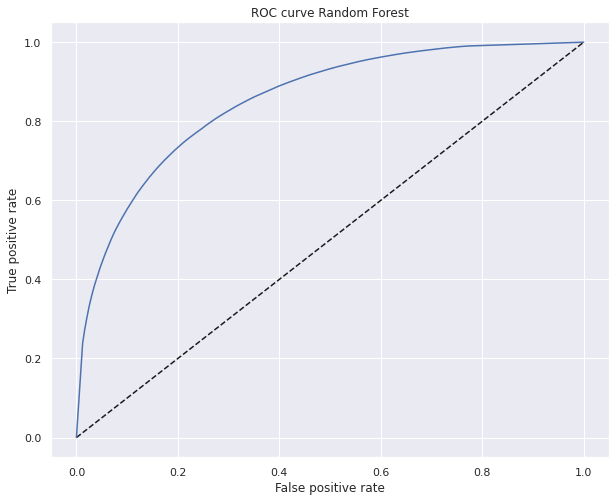

In [25]:
y_pred = clf.predict_proba(X_new_test)
fpr_rf, tpr_rf, _ = roc_curve(y_new_test, tf.nn.softmax(y_pred)[:, 1])
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Random Forest')
plt.show()

## PCA

The most common algorithm used to reduce the number of dimensions is the Principle Component Analysis (PCA). The main idea in PCA is to project an initial space into a subspace that minimizes the projection error. Hence, if we have M vectors in d dimensions, the PCA algorithm wants to find a compression matrix $W$ that induces a mapping $x$ → $Wx$, where $Wx$ is the representation of the lower dimensionality of $x$. Then we want to find a second matrix U capable of recovering the initial $M$ vectors  from their compressed version. To get these two matrices, we need to solve the following optimization problem:
\begin{gather*}
argmin_{W, U} \sum_{i}^{M} \left \| x_i - UWx_i \right \|_2^2
\end{gather*}

The optimal solution is obtained by setting W equal to the eigenvectors with the greatest eigenvalues of the empirical variance-covariance matrix. So, if $\widehat{x}$ represents our standardized samples we have:

\begin{gather*}
varcov(x) = \frac{<\widehat{x}^{t} ,\widehat{x}>}{N_{sample}}
\end{gather*}

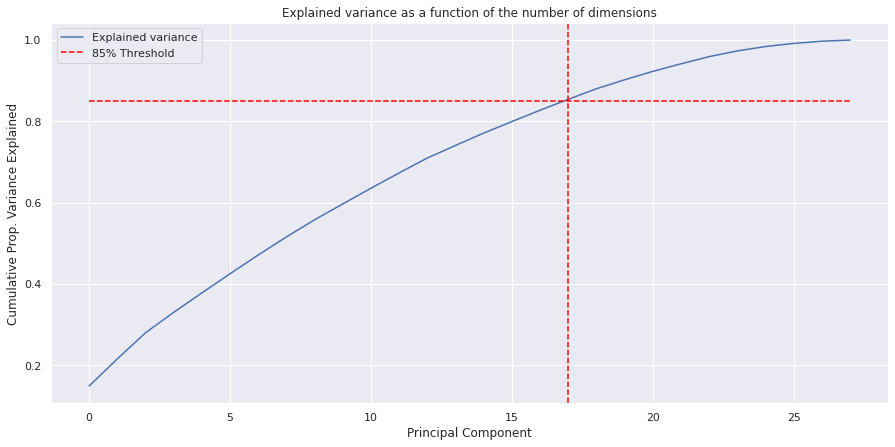

In [26]:
 train_dataset_p, val_dataset_p, test_dataset_p, y_test_p, d = create_datasets(pca = True)

In this case, we get a $28$x$28$ symmetric matrix. From this matrix, we can calculate the values of eigenvectors and eigenvalues. Eigenvectors sorted by eigenvalue magnitude represent the directions in which the variance changes the most. To understand how important each component is, we are interested in knowing the proportion of variance explained (PVE) by each. To calculate, for example, this quantity for the $D^{th}$  main component, we can take the $D^{th}$ eigenvalue and divide it by the sum of all the values of the eigenvalue vector. Therefore, the $D^{th}$ component is always a value in the range [0.1]. So we can track how PVE changes over time and we can also visualize cumulative PVE (CPVE). A commonly used pattern for choosing the right number of main components to use is to look at the cumulative PVE and choose a number of dimensions N where $CPVE(N) > 0.85$.

In [27]:
model = create_dense_model(input_size = d)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 17)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2304      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)             

In [28]:
history_p = model.fit(train_dataset_p, epochs=10, validation_data=val_dataset_p)

Epoch 1/10
3534/3534 [==============================] - 30s 8ms/step - loss: 0.6402 - sparse_categorical_accuracy: 0.6291 - val_loss: 0.6091 - val_sparse_categorical_accuracy: 0.6649
Epoch 2/10
3534/3534 [==============================] - 29s 8ms/step - loss: 0.6163 - sparse_categorical_accuracy: 0.6580 - val_loss: 0.6000 - val_sparse_categorical_accuracy: 0.6740
Epoch 3/10
3534/3534 [==============================] - 29s 8ms/step - loss: 0.6096 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.5934 - val_sparse_categorical_accuracy: 0.6798
Epoch 4/10
3534/3534 [==============================] - 29s 8ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.5894 - val_sparse_categorical_accuracy: 0.6832
Epoch 5/10
3534/3534 [==============================] - 29s 8ms/step - loss: 0.6021 - sparse_categorical_accuracy: 0.6719 - val_loss: 0.5862 - val_sparse_categorical_accuracy: 0.6860
Epoch 6/10
3534/3534 [==============================] - 29s 8ms/step - loss: 0.5997 -

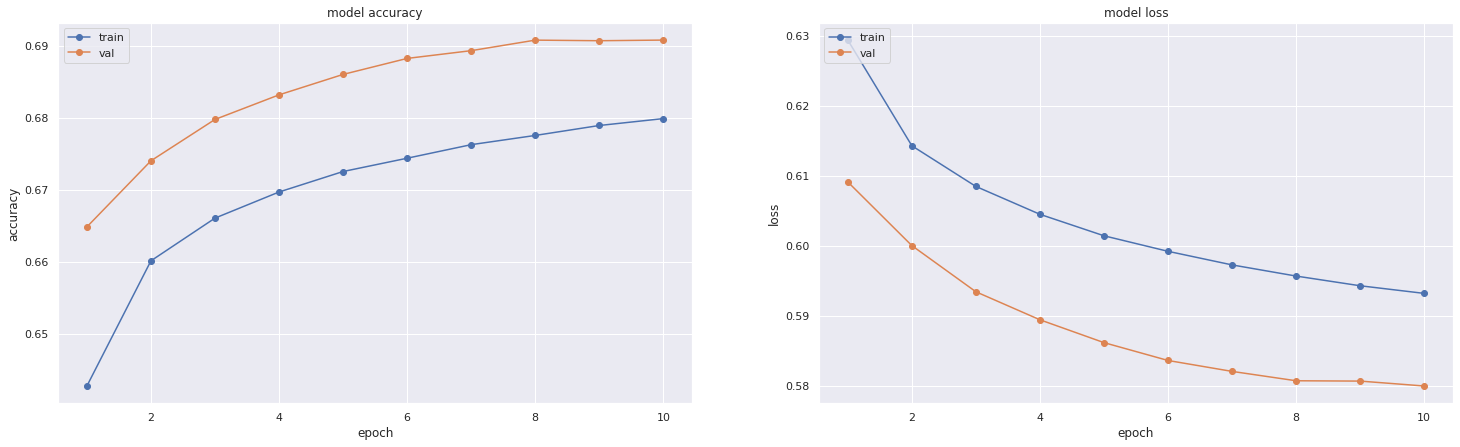

In [29]:
plot_acc_loss(history_p, 10)

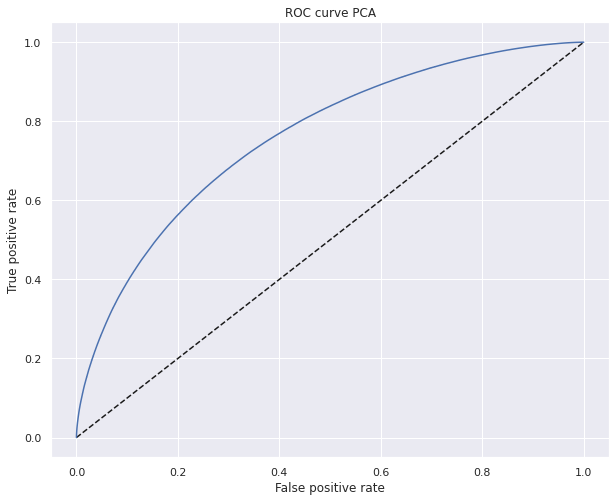

In [30]:
y_pred = model.predict(test_dataset_p)
fpr_rf, tpr_rf, _ = roc_curve(y_test_p, tf.nn.softmax(y_pred)[:, 1])
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve PCA')
plt.show()

The PCA approach doesn't seem to work as well as the old feature extractor. Even if the feature space is larger than before, the result has a significant drop in accuracy.
